In [1]:
!pip install amplpy pyomo -q
!python -m amplpy.modules install coin highs scip gcg -q

In [2]:

from amplpy import modules
import pyomo.environ as pyo
import pandas as pd
import numpy as np
from pyomo.environ import *


import matplotlib.pyplot as plt
import networkx as nx
import requests



# Caso 1

In [3]:
clientes_data = pd.read_csv(r"C:\Users\ACER\OneDrive - Universidad de los Andes\Escritorio\MOS\PROY2_MOS\Proyecto Seneca Libre\case_1_base\Clients.csv")
print(clientes_data.shape)
clientes_data.sample(5)


(24, 5)


,ClientID,LocationID,Product,Longitude,Latitude
12,13,25,21,-74.096909,4.646217
10,11,23,17,-74.178023,4.591594
14,15,27,17,-74.094295,4.604168
5,6,18,17,-74.120838,4.662137
3,4,16,15,-74.097280,4.605029


In [4]:
depositos_data = pd.read_csv(r"C:\Users\ACER\OneDrive - Universidad de los Andes\Escritorio\MOS\PROY2_MOS\Proyecto Seneca Libre\case_1_base\Depots.csv")
print(depositos_data.shape)
depositos_data.sample(5)

(12, 4)


,DepotID,LocationID,Longitude,Latitude
1,2,2,-74.109934,4.536383
2,3,3,-74.038548,4.792926
7,8,8,-74.109756,4.678961
3,4,4,-74.067069,4.721678
8,9,9,-74.095472,4.735973


In [5]:
ubicaciones_data = pd.concat([depositos_data[["LocationID","Longitude", "Latitude"]], clientes_data[["LocationID","Longitude", "Latitude"]]], axis = 0)
print(ubicaciones_data.shape)
ubicaciones_data.sample(15)

(36, 3)


,LocationID,Longitude,Latitude
22,35,-74.116526,4.731407
9,10,-74.109916,4.550641
6,19,-74.022131,4.697499
16,29,-74.124639,4.615869
23,36,-74.126293,4.577490
1,2,-74.109934,4.536383
10,23,-74.178023,4.591594
15,28,-74.111388,4.557321
17,30,-74.124562,4.656403
6,7,-74.095619,4.621912


In [6]:
vehiculos = pd.read_csv(r"C:\Users\ACER\OneDrive - Universidad de los Andes\Escritorio\MOS\PROY2_MOS\Proyecto Seneca Libre\case_1_base\Vehicles.csv")
print(vehiculos.shape)
vehiculos.sample(5)

(12, 3)


,VehicleType,Capacity,Range
4,EV,86.986092,1108.512009
3,Gas Car,157.901108,173.023042
6,EV,100.645676,617.343951
7,EV,62.881578,887.542494
0,Gas Car,131.921140,145.852071


In [7]:
vehiculos_data= pd.read_csv(r"C:\Users\ACER\OneDrive - Universidad de los Andes\Escritorio\MOS\PROY2_MOS\Proyecto Seneca Libre\vehicles_data.csv")
print(vehiculos_data.shape)
vehiculos_data.sample(3)

(3, 9)


,Vehicle,Freight Rate [COP/km],Time Rate [COP/min],Daily Maintenance [COP/day],Recharge/Fuel Cost [COP/(gal or kWh)],Recharge/Fuel Time [min/10 percent charge],Avg. Speed [km/h],Gas Efficiency [km/gal],Electricity Efficency [kWh/km]
2,Solar EV,4000,500,21000,NaN,NaN,NaN,NaN,0.15
0,Gas Car,5000,500,30000,16000.00,0.1,NaN,10.0,NaN
1,Drone,500,500,3000,220.73,2.0,40.0,NaN,0.15


In [8]:
# DataFrame 2 (datos de vehículos)
vehiculos_data = pd.DataFrame({
    'Vehicle': ['Gas Car', 'EV', 'Drone'],
    'Freight Rate [COP/km]': [5000, 4000, 500],
    'Time Rate [COP/min]': [500, 500, 500],
    'Daily Maintenance [COP/day]': [30000, 21000, 3000],
    'Recharge/Fuel Cost [COP/gal or kWh]': [16000, None, 220.73],
    'Recharge/Fuel Time [min/10 percent charge]': [0.1, None, 2.0],
    'Avg. Speed [km/h]': [None, None, 40.0],
    'Gas Efficiency [km/gal]': [10.0, None, None],
    'Electricity Efficiency [kWh/km]': [None, 0.15, 0.15]
})


# Realizar nuevamente el merge entre los DataFrames
vehiculos_info = vehiculos.merge(vehiculos_data, left_on='VehicleType', right_on='Vehicle', how='left')

vehiculos_info.sample(5)

,VehicleType,Capacity,Range,Vehicle,Freight Rate [COP/km],Time Rate [COP/min],Daily Maintenance [COP/day],Recharge/Fuel Cost [COP/gal or kWh],Recharge/Fuel Time [min/10 percent charge],Avg. Speed [km/h],Gas Efficiency [km/gal],Electricity Efficiency [kWh/km]
2,Gas Car,114.380319,142.975891,Gas Car,5000,500,30000,16000.0,0.1,NaN,10.0,NaN
6,EV,100.645676,617.343951,EV,4000,500,21000,NaN,NaN,NaN,NaN,0.15
9,Gas Car,78.600000,133.130000,Gas Car,5000,500,30000,16000.0,0.1,NaN,10.0,NaN
0,Gas Car,131.921140,145.852071,Gas Car,5000,500,30000,16000.0,0.1,NaN,10.0,NaN
10,EV,84.450000,1370.460000,EV,4000,500,21000,NaN,NaN,NaN,NaN,0.15


In [34]:
#Reemplazar los valores nulos de cada columna por 0
vehiculos_info.fillna(0, inplace=True)
vehiculos_info.sample(6)

,VehicleType,Capacity,Range,Vehicle,Freight Rate [COP/km],Time Rate [COP/min],Daily Maintenance [COP/day],Recharge/Fuel Cost [COP/gal or kWh],Recharge/Fuel Time [min/10 percent charge],Avg. Speed [km/h],Gas Efficiency [km/gal],Electricity Efficiency [kWh/km],Vehicle_ID
1,Gas Car,135.544525,195.690896,Gas Car,5000,500,30000,16000.0,0.1,0.0,10.0,0.00,1
8,EV,76.553642,1062.849467,EV,4000,500,21000,0.0,0.0,0.0,0.0,0.15,8
10,EV,84.450000,1370.460000,EV,4000,500,21000,0.0,0.0,0.0,0.0,0.15,10
11,Gas Car,131.920000,145.850000,Gas Car,5000,500,30000,16000.0,0.1,0.0,10.0,0.00,11
7,EV,62.881578,887.542494,EV,4000,500,21000,0.0,0.0,0.0,0.0,0.15,7
4,EV,86.986092,1108.512009,EV,4000,500,21000,0.0,0.0,0.0,0.0,0.15,4


In [10]:
num_clientes = 24
clientes_id = RangeSet(1, num_clientes)

In [11]:
num_vehiculos = 11
vehiculos_r = RangeSet(0, num_vehiculos)

In [12]:
num_depositos = 12
deposito_origen = RangeSet(1, num_depositos)  # Definir ciudad de origen


In [13]:
num_ubicaciones = num_clientes + num_depositos
ubicaciones = RangeSet(1, num_ubicaciones)


In [14]:
result = ";".join(f"{row['Longitude']},{row['Latitude']}" for _, row in ubicaciones_data.iterrows())
print(result)
url = f"http://router.project-osrm.org/table/v1/driving/{result}?annotations=distance,duration"

response = requests.get(url)

if response.status_code == 200:
    print(response.json().keys())
else:
    # Manejo de errores
    print("Error:", response.status_code, response.json().get("message", "Unknown error"))
costos_distancia = np.array(response.json()["distances"])/1000
costos_duracion = np.array(response.json()["durations"])/60
print(costos_distancia.shape, costos_duracion.shape)
costos_distancia, costos_duracion

-74.08124218159384,4.75021190869025;-74.10993358606953,4.5363832206427785;-74.03854814565923,4.792925960208614;-74.06706883098641,4.72167778077445;-74.13826337931849,4.607707046760958;-74.12400186370824,4.650463053612691;-74.09561875464892,4.621911772492814;-74.10975623736951,4.678960680833056;-74.09547235719887,4.735973062153282;-74.10991610076434,4.550640992537941;-74.10977422186991,4.664702960902753;-74.12408925943333,4.5791740634103135;-74.09893796560621,4.59795431125545;-74.07557103763986,4.687820646838871;-74.10708524062704,4.70949446000624;-74.09727965657427,4.605029068682624;-74.16464148202755,4.648463876533332;-74.12083799988112,4.662137416953968;-74.02213076607309,4.697499030379109;-74.17207549744595,4.649416884236942;-74.15615257246444,4.606310650273935;-74.09041145358674,4.557379705282216;-74.17802255204528,4.591594072172954;-74.1015410917749,4.7564172406324055;-74.09690889182339,4.646217006050524;-74.1219200708342,4.725912125314368;-74.0942948461378,4.604168478560718;-74.1

(array([[ 0.    , 33.0616, 10.1619, ..., 20.3231, 12.7272, 26.4218],
        [32.9469,  0.    , 34.1815, ..., 14.3162, 31.4658, 11.1634],
        [14.3307, 38.9127,  0.    , ..., 25.7292, 26.2725, 32.2729],
        ...,
        [19.2004, 14.9417, 21.1949, ...,  0.    , 17.7193,  8.3019],
        [ 9.7937, 29.6986, 22.382 , ..., 16.5151,  0.    , 23.0588],
        [25.255 ,  6.4714, 30.3994, ...,  9.608 , 23.7739,  0.    ]]),
 array([[ 0.        , 41.80333333, 17.565     , ..., 22.61166667,
         14.245     , 33.59      ],
        [41.70833333,  0.        , 42.285     , ..., 20.86      ,
         37.285     , 14.145     ],
        [19.80333333, 52.98666667,  0.        , ..., 34.08333333,
         30.06666667, 44.77333333],
        ...,
        [23.78166667, 20.68666667, 24.1       , ...,  0.        ,
         19.35833333, 12.47333333],
        [12.5       , 38.17166667, 23.22      , ..., 19.26833333,
          0.        , 29.95833333],
        [31.21166667, 12.76166667, 34.86833333, 

In [15]:
from pyomo.environ import *
import pandas as pd
import numpy as np

In [16]:
model = pyo.ConcreteModel()

In [17]:
# Eliminar los componentes existentes antes de redefinirlos
if "N" in model.component_map():
    model.del_component("N")
if "C" in model.component_map():
    model.del_component("C")
if "D" in model.component_map():
    model.del_component("D")

In [18]:
model.C = Set(initialize=clientes_data['LocationID'].tolist())  # Clientes
model.D = Set(initialize=depositos_data['LocationID'].tolist())  # Depósitos
vehiculos_info["Vehicle_ID"] = vehiculos_info.index.astype(int)  # Crear un identificador único si no existe
model.V = Set(initialize=vehiculos_info["Vehicle_ID"].tolist())
model.N = Set(initialize=list(model.C) + list(model.D)) # Nodos

In [19]:
# Parámetros ajustados
model.capacity = pyo.Param(model.V, initialize=dict(zip(vehiculos_info["Vehicle_ID"], vehiculos_info["Capacity"])))
model.range = pyo.Param(model.V, initialize=dict(zip(vehiculos_info["Vehicle_ID"], vehiculos_info["Range"])))
model.cost_per_km = pyo.Param(model.V, initialize=dict(zip(vehiculos_info["Vehicle_ID"], vehiculos_info["Freight Rate [COP/km]"])))
model.cost_per_min = pyo.Param(model.V, initialize=dict(zip(vehiculos_info["Vehicle_ID"], vehiculos_info["Time Rate [COP/min]"])))
model.cost_per_combustible = pyo.Param(model.V, initialize=dict(zip(vehiculos_info["Vehicle_ID"], vehiculos_info["Recharge/Fuel Cost [COP/gal or kWh]"])))
model.cost_per_load = pyo.Param(initialize=100)# Parámetro de costo por unidad de carga transportada (por ejemplo, COP por kg)


# Demanda por cliente
model.demand = pyo.Param(model.C, initialize=dict(zip(clientes_data["LocationID"], clientes_data["Product"])))

# Costos por distancia
dist_dict = {
    (ubicaciones_data.iloc[i]["LocationID"], ubicaciones_data.iloc[j]["LocationID"]): costos_distancia[i, j]
    for i in range(num_ubicaciones)
    for j in range(num_ubicaciones)
    if i != j
}

model.distances = pyo.Param(model.N, model.N, initialize=dist_dict, default=0)

# Costos por duración
dura_dict = {
    (ubicaciones_data.iloc[i]["LocationID"], ubicaciones_data.iloc[j]["LocationID"]): costos_duracion[i, j]
    for i in range(num_ubicaciones)
    for j in range(num_ubicaciones)
    if i != j
}

model.durations = pyo.Param(model.N, model.N, initialize=dura_dict, default=0)

# Costo de mantenimiento diario de cada vehículo
model.maintenance_cost = pyo.Param(model.V, initialize=dict(zip(vehiculos_info["Vehicle_ID"], vehiculos_info["Daily Maintenance [COP/day]"])))


In [20]:
model.cost_per_combustible.pprint()

cost_per_combustible : Size=12, Index=V, Domain=Any, Default=None, Mutable=False
    Key : Value
      0 : 16000.0
      1 : 16000.0
      2 : 16000.0
      3 : 16000.0
      4 :     0.0
      5 :     0.0
      6 :     0.0
      7 :     0.0
      8 :     0.0
      9 : 16000.0
     10 :     0.0
     11 : 16000.0


In [21]:
# del model.x
# del model.u
# del model.v_use
# del model.carga

In [21]:
# Variables binarias para rutas
model.x = pyo.Var(model.N, model.N, model.V, domain=pyo.Binary)

# Variable auxiliar para el orden de visita
model.u = pyo.Var(model.C, model.V, within=pyo.NonNegativeIntegers)

# Varaible auxiliar para saber si un vehículo es utilizado
model.v_use = pyo.Var(model.V, within=pyo.Binary)

# Variable que controla la carga que lleva cada vehiculo
model.carga = pyo.Var(model.N, model.N, model.V, domain=pyo.NonNegativeReals)


In [22]:
if "objective" in model.component_map():
    model.del_component("objective")

In [23]:
# Función objetivo ajustada
def objective_rule(model):
    # Costo por distancia recorrida
    cost_distance = sum(model.cost_per_km[v] * model.distances[i, j] * model.x[i, j, v]
                        for v in model.V for i in model.N for j in model.N if i != j)
    
    # Costo por duración del trayecto
    cost_duration = sum(model.cost_per_min[v] * model.durations[i, j] * model.x[i, j, v]
                        for v in model.V for i in model.N for j in model.N if i != j)
    
    # Costos de mantenimiento
    cost_maintenance = sum(model.maintenance_cost[v] * model.v_use[v] for v in model.V)       
    
    #Costo de carga por demanda cubierta
    cost_load = sum(model.cost_per_load* model.demand[i] * model.x[i, j, v]
                        for v in model.V for i in model.C for j in model.N if i != j)
    
    # Costo de carga de combustible y costo por tiempo de carga de combustible
    cost_fuel=0
    cost_recharge=0
    for v in model.V:
        for i in model.N:
            for j in model.N:
                if i != j:
                    if vehiculos_info.iloc[v]["Gas Efficiency [km/gal]"]!=0:
                        cost_fuel+=model.cost_per_combustible[v] * model.distances[i, j]*model.x[i,j,v]*(1/vehiculos_info.iloc[v]["Gas Efficiency [km/gal]"])
                        cost_recharge+=model.cost_per_min[v] * ((model.distances[i, j]*model.x[i,j,v]*(1/vehiculos_info.iloc[v]["Gas Efficiency [km/gal]"]))*(1/vehiculos_info.iloc[v]["Recharge/Fuel Time [min/10 percent charge]"]))
                    else:
                        cost_fuel+=0
                        cost_recharge+=0
    # Suma total de costos
    return cost_distance + cost_duration + cost_maintenance + cost_load + cost_fuel + cost_recharge

model.objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

In [24]:
# Eliminar restricciones del modelo
# del model.visit_once
# del model.flow_conservation
# del model.satisfy_demand
# del model.vehicle_capacity
# del model.vehicle_capacity_01
# del model.subtour_elimination
# del model.return_to_depot
# del model.depot_salida
# del model.vehicle_used
# del model.vehicle_range

In [24]:
#RESTRICCIONES

# Restricciones de vista una vez
def visit_once_rule(model, i):
    return sum(model.x[i, j, v] for v in model.V for j in model.N if i != j) == 1

model.visit_once = pyo.Constraint(model.C, rule=visit_once_rule)

#Restricción conservación de flujo
def flow_conservation_rule(model, v, i):
    return sum(model.x[i, j, v] for j in model.N if i != j) == sum(model.x[j, i, v] for j in model.N if i != j)

model.flow_conservation = pyo.Constraint(model.V, model.N, rule=flow_conservation_rule)


# Restricción para habilitar la variable auxiliar v_use
def vehicle_used_rule(model, v):
    return model.v_use[v]*len(model.N) >= sum(model.x[i, j, v] for i in model.N for j in model.N if i != j)
model.vehicle_used = pyo.Constraint(model.V, rule=vehicle_used_rule)

#Restrcción de rango
def vehicle_range_rule(model, v):
    return sum(model.distances[i, j]*model.x[i, j, v] for i in model.N for j in model.N if i != j) <= model.range[v]
model.vehicle_range = pyo.Constraint(model.V, rule=vehicle_range_rule)

#Restricción salida de deposito
def depot_salida_rule(model, v):
    return sum(model.x[d, j, v] for d in model.D for j in model.C) == 1
model.depot_salida = pyo.Constraint(model.V, rule=depot_salida_rule)


# Restricción para garantizar que los vehículos regresen al depósito de salida
def return_to_depot_rule(model, v, d):
    return sum(model.x[d, j, v] for j in model.N if j != d) == sum(model.x[j, d, v] for j in model.N if j != d)

model.return_to_depot = pyo.Constraint(model.V, model.D, rule=return_to_depot_rule)

# Restricción de capacidad de los vehículos
def vehicle_capacity_rule(model, v):
    return sum(model.demand[i]*model.x[i, j, v] for i in model.C for j in model.N if i != j) <= model.capacity[v]

model.vehicle_capacity_01 = pyo.Constraint(model.V, rule=vehicle_capacity_rule)

# Restricción de capacidad de los vehículos
def vehicle_capacity_rule(model, i, j, v):
    return model.carga[i, j, v] <= model.capacity[v] * model.x[i, j, v]
model.vehicle_capacity = pyo.Constraint(model.N, model.N, model.V, rule=vehicle_capacity_rule)

# Restricción para satisfacer la demanda de cada cliente
def satisfy_demand_rule(model, i):
    return sum(model.carga[i, j, v] for j in model.N for v in model.V if j != i) == model.demand[i]
model.satisfy_demand = pyo.Constraint(model.C, rule=satisfy_demand_rule)


# Restricción de subtour elimination (MTZ)
def subtour_elimination_rule(model, v, i, j):
    if i != j and i not in model.D and j not in model.D:  # Aplica a nodos diferentes
        return model.u[i,v] - model.u[j,v] + len(model.C) * model.x[i, j, v] <= len(model.C) - 1
    else:
        return pyo.Constraint.Skip

model.subtour_elimination = pyo.Constraint(model.V, model.C, model.C, rule=subtour_elimination_rule)


In [25]:
class modelSolver:
    def __init__(self, model):
        self.model = model

    def solve_model(self):
        # Definir el solver
        solver_name = "highs"  # Asegúrate de tener este solver instalado y disponible
        solver = pyo.SolverFactory(solver_name+"nl", executable=modules.find(solver_name), solver_io="nl")

        # Configurar opciones avanzadas del solver
        solver.options['parallel'] = 'on'  # Habilitar paralelismo
        solver.options['time_limit'] = 3600  # Límite de tiempo (1 hora)
        solver.options['presolve'] = 'on'  # Habilitar preprocesamiento
        solver.options['mip_rel_gap'] = 0.01  # Gap relativo del 1% (para MIP)

        # Resolver el modelo
        result = solver.solve(self.model, tee=True)
        print(result.solver.status)
        print(result.solver.termination_condition)

        # Verificar el estado de la solución
        if result.solver.termination_condition == pyo.TerminationCondition.optimal:
            print("Optimal solution found.")
        elif result.solver.termination_condition == pyo.TerminationCondition.maxTimeLimit:
            print("Time limit reached, solution may be suboptimal.")
        else:
            print(f"Solver terminated with condition: {result.solver.termination_condition}")

        # Mostrar el resultado
        print(result)


In [26]:
solver = modelSolver(model)
solver.solve_model()

HiGHS 1.8.1:   alg:parallel = on
  lim:time = 3600
  pre:solve = on
  mip:gap = 0.01
ok
optimal
Optimal solution found.

Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 22848
  Number of variables: 31404
  Sense: unknown
Solver: 
- Status: ok
  Message: HiGHS 1.8.1\x3a optimal solution; objective 1077041.63333333; 116738 simplex iterations; 140 branching nodes; absmipgap=10764.8, relmipgap=0.00999475
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 164.06581497192383
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [27]:
for i in model.C:
    entrega_total = sum(pyo.value(model.carga[i, j, v]) for j in model.N for v in model.V if j != i)
    print(f"Cliente {i}: Demanda = {model.demand[i]}, Entrega total = {round(entrega_total)}")

Cliente 13: Demanda = 13, Entrega total = 13
Cliente 14: Demanda = 15, Entrega total = 15
Cliente 15: Demanda = 12, Entrega total = 12
Cliente 16: Demanda = 15, Entrega total = 15
Cliente 17: Demanda = 20, Entrega total = 20
Cliente 18: Demanda = 17, Entrega total = 17
Cliente 19: Demanda = 17, Entrega total = 17
Cliente 20: Demanda = 20, Entrega total = 20
Cliente 21: Demanda = 20, Entrega total = 20
Cliente 22: Demanda = 15, Entrega total = 15
Cliente 23: Demanda = 17, Entrega total = 17
Cliente 24: Demanda = 12, Entrega total = 12
Cliente 25: Demanda = 21, Entrega total = 21
Cliente 26: Demanda = 15, Entrega total = 15
Cliente 27: Demanda = 17, Entrega total = 17
Cliente 28: Demanda = 10, Entrega total = 10
Cliente 29: Demanda = 25, Entrega total = 25
Cliente 30: Demanda = 12, Entrega total = 12
Cliente 31: Demanda = 11, Entrega total = 11
Cliente 32: Demanda = 15, Entrega total = 15
Cliente 33: Demanda = 14, Entrega total = 14
Cliente 34: Demanda = 18, Entrega total = 18
Cliente 35

In [28]:
for v in model.V:
    entrega_total = sum(pyo.value(model.carga[i, j, v]) for i in model.N for j in model.N  if j != i)
    print(f"Vehiculo {v}: Capacidad = {model.capacity[v]}, Capacidad asignada = {entrega_total}")

Vehiculo 0: Capacidad = 131.9211396722696, Capacidad asignada = 15.0
Vehiculo 1: Capacidad = 135.54452491441663, Capacidad asignada = 18.0
Vehiculo 2: Capacidad = 114.38031900663994, Capacidad asignada = 12.0
Vehiculo 3: Capacidad = 157.9011075721774, Capacidad asignada = 20.0
Vehiculo 4: Capacidad = 86.98609179004892, Capacidad asignada = 36.0
Vehiculo 5: Capacidad = 87.10238029800072, Capacidad asignada = 45.0
Vehiculo 6: Capacidad = 100.64567561406786, Capacidad asignada = 42.0
Vehiculo 7: Capacidad = 62.88157761574977, Capacidad asignada = 29.0
Vehiculo 8: Capacidad = 76.55364248957906, Capacidad asignada = 57.0
Vehiculo 9: Capacidad = 78.6, Capacidad asignada = 10.0
Vehiculo 10: Capacidad = 84.45, Capacidad asignada = 82.0
Vehiculo 11: Capacidad = 131.92, Capacidad asignada = 11.0


Rutas seleccionadas para el viajero 0: [(10, 22), (22, 10)]
Rutas seleccionadas para el viajero 1: [(7, 34), (34, 7)]
Rutas seleccionadas para el viajero 2: [(1, 24), (24, 1)]
Rutas seleccionadas para el viajero 3: [(5, 21), (21, 5)]
Rutas seleccionadas para el viajero 4: [(11, 14), (14, 25), (25, 11)]
Rutas seleccionadas para el viajero 5: [(7, 13), (13, 27), (16, 7), (27, 16)]
Rutas seleccionadas para el viajero 6: [(4, 33), (19, 31), (31, 4), (33, 19)]
Rutas seleccionadas para el viajero 7: [(6, 18), (18, 30), (30, 6)]
Rutas seleccionadas para el viajero 8: [(9, 15), (15, 26), (26, 35), (32, 9), (35, 32)]
Rutas seleccionadas para el viajero 9: [(10, 28), (28, 10)]
Rutas seleccionadas para el viajero 10: [(5, 29), (17, 20), (20, 23), (23, 5), (29, 17)]
Rutas seleccionadas para el viajero 11: [(12, 36), (36, 12)]


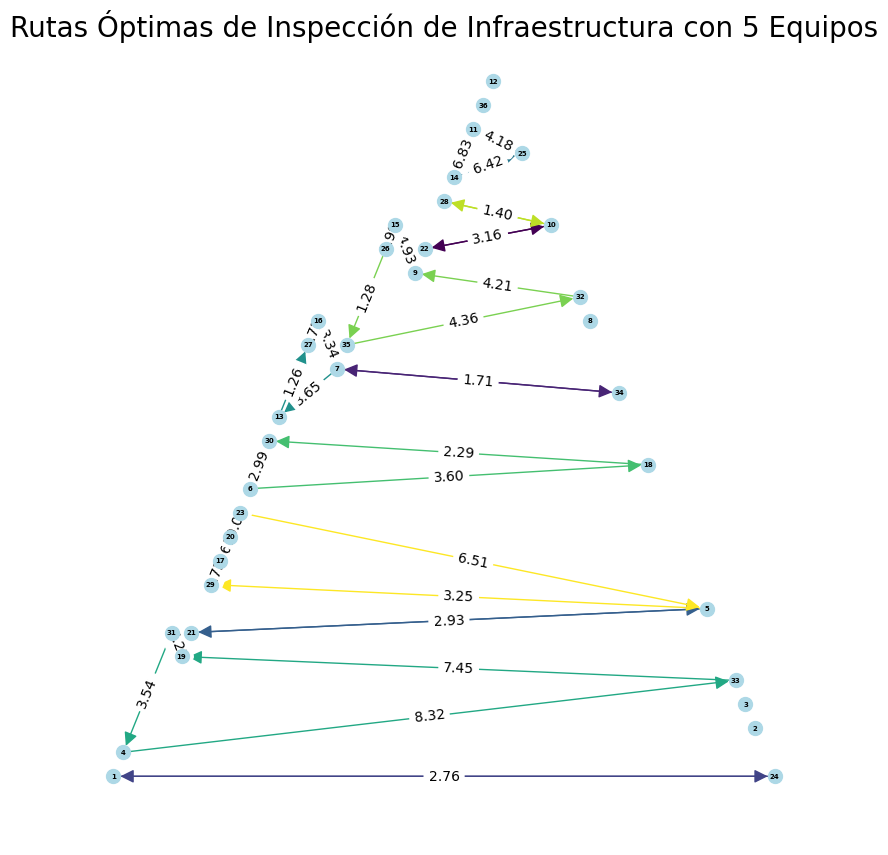

{1: array([-0.84476262, -0.39412208]),
 2: array([ 0.94574228, -0.33986436]),
 3: array([ 0.91861341, -0.31273549]),
 4: array([-0.81763376, -0.36699322]),
 5: array([ 0.81009797, -0.20422005]),
 6: array([-0.46495855, -0.06857573]),
 7: array([-0.22079879,  0.06706858]),
 8: array([0.48455162, 0.1213263 ]),
 9: array([-0.0037679 ,  0.17558402]),
 10: array([0.37603617, 0.22984175]),
 11: array([0.15900528, 0.3383572 ]),
 12: array([0.213263  , 0.39261492]),
 13: array([-0.38357197,  0.01281085]),
 14: array([0.10474755, 0.28409947]),
 15: array([-0.05802562,  0.22984175]),
 16: array([-0.27505652,  0.1213263 ]),
 17: array([-0.54634514, -0.14996232]),
 18: array([ 0.64732479, -0.04144687]),
 19: array([-0.65486059, -0.25847777]),
 20: array([-0.51921628, -0.12283346]),
 21: array([-0.62773173, -0.23134891]),
 22: array([0.02336096, 0.20271289]),
 23: array([-0.49208742, -0.0957046 ]),
 24: array([ 1.        , -0.39412208]),
 25: array([0.29464959, 0.31122833]),
 26: array([-0.08515448

In [29]:

# Extraer las rutas seleccionadas
selected_routes = []
for k in model.V:
    routes_for_k = [(i, j) for i in ubicaciones for j in ubicaciones if i != j and round(model.x[i, j, k].value) == 1]
    print(f"Rutas seleccionadas para el viajero {k}: {routes_for_k}")
    selected_routes.append(routes_for_k)

# Crear el grafo usando NetworkX
G = nx.DiGraph()

# Añadir ubicaciones
for i in ubicaciones:
    G.add_node(i)

for k in range(num_vehiculos):
    for route in selected_routes[k]:
        i, j = route
        G.add_edge(i, j, weight=f"{costos_distancia[i-1,j-1]:.2f}",color=k)

# Dibujar el grafo
edges = G.edges()
edge_colors = [G[u][v]['color'] for u, v in edges]
pos = nx.planar_layout(G)  # Usar un layout circular para una visualización clara
labels = nx.get_edge_attributes(G, 'weight')

plt.figure(figsize=(8, 8))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=100, font_size=5, font_weight='bold', arrowsize=20, edge_color=edge_colors)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.title("Rutas Óptimas de Inspección de Infraestructura con 5 Equipos", size=20)
plt.show()
pos

In [30]:
!pip install folium


In [31]:
from folium import features
from folium.plugins import AntPath

#from geopy.distance import geodesic

In [32]:

import folium


selected_routes = []
for v in model.V:
    routes_for_v = [(i, j) for i in model.N for j in model.N if i != j and np.round(model.x[i, j, v].value) == 1]
    print(f"Rutas seleccionadas para el viajero {v}: {routes_for_v}")
    selected_routes.append(routes_for_v)


coordenadas = {}
for i in ubicaciones:
    coordenadas[i] ={"coor":(ubicaciones_data["Latitude"].iloc[i-1], ubicaciones_data["Longitude"].iloc[i-1])}

colors = ['green', 'orange', 'darkblue','darkred', 'red', 'purple']
node_colors = {}
for v in range(len(model.V)):
    for route in selected_routes[v]:
        i, j = route
        idx_color = v%len(colors)
        if i not in node_colors and i > len(model.D):
            coordenadas[i]["v"] = v
            node_colors[i] = colors[idx_color]
        if j not in node_colors and j > len(model.D):
            coordenadas[j]["v"] = v
            node_colors[j] = colors[idx_color]

# Crear el mapa centrado en la primera ubicación
mapa = folium.Map(location=coordenadas[1]["coor"], zoom_start=11)
for idx in coordenadas:
    lat, lon = coordenadas[idx]["coor"]
    icon, color, v= ("warehouse", 'gray', "") if idx <= len(model.D) else ("home", node_colors.get(idx, "black"), coordenadas[idx].get("v", -2) )

    if idx <= len(model.D):
        folium.Marker(
            location=(lat, lon),
            popup=f"Depósito: {idx}",
            icon=folium.Icon(color=color, icon=icon, prefix="fa"),
        ).add_to(mapa)
    else:
        folium.Marker(
            location=(lat, lon),
            popup=f"Cliente: {idx-12}, LocationID: {idx}, Demanda: {model.demand[idx]} uds, v: {v}",
            icon=folium.Icon(color=color, icon=icon, prefix="fa"),
        ).add_to(mapa)

for v in range(len(model.V)):
    for route in selected_routes[v]:
        i, j = route
        idx_color = v%len(colors)
        
        AntPath(
            locations=[coordenadas[i]["coor"], coordenadas[j]["coor"]],
            tooltip=f"Distancia: {costos_distancia[i - 1, j - 1]:.2f} km",
            color= colors[idx_color],
        ).add_to(mapa)
        

# Mostrar el mapa
mapa.save("mapa.html")
mapa

Rutas seleccionadas para el viajero 0: [(22, 10), (10, 22)]
Rutas seleccionadas para el viajero 1: [(34, 7), (7, 34)]
Rutas seleccionadas para el viajero 2: [(24, 1), (1, 24)]
Rutas seleccionadas para el viajero 3: [(21, 5), (5, 21)]
Rutas seleccionadas para el viajero 4: [(14, 25), (25, 11), (11, 14)]
Rutas seleccionadas para el viajero 5: [(13, 27), (16, 7), (27, 16), (7, 13)]
Rutas seleccionadas para el viajero 6: [(19, 31), (31, 4), (33, 19), (4, 33)]
Rutas seleccionadas para el viajero 7: [(18, 30), (30, 6), (6, 18)]
Rutas seleccionadas para el viajero 8: [(15, 26), (26, 35), (32, 9), (35, 32), (9, 15)]
Rutas seleccionadas para el viajero 9: [(28, 10), (10, 28)]
Rutas seleccionadas para el viajero 10: [(17, 20), (20, 23), (23, 5), (29, 17), (5, 29)]
Rutas seleccionadas para el viajero 11: [(36, 12), (12, 36)]


In [ ]:
#Generar dataframe con el resporte de costos para cada vehículo
costos = []
for v in model.V:
    tipo_vehiculo = vehiculos_info.iloc[v]["VehicleType"]
    distancia_recorrida = sum(model.distances[i, j] * model.x[i, j, v].value for i in model.N for j in model.N if i != j)   
    tiempo_recorrido = sum(model.durations[i, j] * model.x[i, j, v].value for i in model.N for j in model.N if i != j)
    carga_total = sum(model.demand[i] * model.x[i, j, v].value for i in model.C for j in model.N if i != j)
    costo_km = sum(model.cost_per_km[v] * model.distances[i, j] * model.x[i, j, v].value for i in model.N for j in model.N if i != j)
    costo_min = sum(model.cost_per_min[v] * model.durations[i, j] * model.x[i, j, v].value for i in model.N for j in model.N if i != j)
    costo_mantenimiento = model.maintenance_cost[v] * model.v_use[v].value
    costo_carga = sum(model.cost_per_load * model.demand[i] * model.x[i, j, v].value for i in model.C for j in model.N if i != j)
    costo_combustible = sum(model.cost_per_combustible[v] * model.distances[i, j] * model.x[i, j, v].value * (1/vehiculos_info.iloc[v]["Gas Efficiency [km/gal]"]) for i in model.N for j in model.N if i != j)
    costo_recarga = sum(model.cost_per_min[v] * ((model.distances[i, j] * model.x[i, j, v].value * (1/vehiculos_info.iloc[v]["Gas Efficiency [km/gal]"])) * (1/vehiculos_info.iloc[v]["Recharge/Fuel Time [min/10 percent charge]"])) for i in model.N for j in model.N if i != j)
    costo_total = costo_km + costo_min + costo_mantenimiento + costo_carga + costo_combustible + costo_recarga
    costos.append([v, tipo_vehiculo, distancia_recorrida, tiempo_recorrido,carga_total, costo_km, costo_min, costo_mantenimiento, costo_carga, costo_combustible, costo_recarga, costo_total])
    
costos_df = pd.DataFrame(costos, columns=["Vehículo", "Tipo", "Distancia recorrida (km)","Tiempo recorrido (min)", "Carga total","Costo por Distancia", "Costo por Tiempo", "Costo de mantenimiento", "Costo de carga", "Costo de combustible", "Costo de Tiempo recarga de combustible", "Costo total"])
costos_df.fillna(0, inplace=True)
costos_df

C:\Users\ACER\AppData\Local\Temp\ipykernel_23916\1356495163.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  costo_combustible = sum(model.cost_per_combustible[v] * model.distances[i, j] * model.x[i, j, v].value * (1/vehiculos_info.iloc[v]["Gas Efficiency [km/gal]"]) for i in model.N for j in model.N if i != j)
C:\Users\ACER\AppData\Local\Temp\ipykernel_23916\1356495163.py:11: RuntimeWarning: invalid value encountered in scalar multiply
  costo_combustible = sum(model.cost_per_combustible[v] * model.distances[i, j] * model.x[i, j, v].value * (1/vehiculos_info.iloc[v]["Gas Efficiency [km/gal]"]) for i in model.N for j in model.N if i != j)
C:\Users\ACER\AppData\Local\Temp\ipykernel_23916\1356495163.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  costo_recarga = sum(model.cost_per_min[v] * ((model.distances[i, j] * model.x[i, j, v].value * (1/vehiculos_info.iloc[v]["Gas Efficiency [km/gal]"])) * (1/vehiculos_info.iloc[v]["Recharge/Fuel Time [min/1

,Vehículo,Tipo,Distancia recorrida (km),Tiempo recorrido (min),Costo por Distancia,Costo por Tiempo,Costo de mantenimiento,Costo de carga,Costo de combustible,Costo de Tiempo recarga de combustible,Costo total
0,0,Gas Car,6.7118,11.760000,33559.0,5880.000000,30000.0,1500.0,10738.88,3355.90,85033.780000
1,1,Gas Car,5.7917,9.436667,28958.5,4718.333333,30000.0,1800.0,9266.72,2895.85,77639.403333
2,2,Gas Car,5.6052,9.041667,28026.0,4520.833333,30000.0,1200.0,8968.32,2802.60,75517.753333
3,3,Gas Car,5.5040,13.236667,27520.0,6618.333333,30000.0,2000.0,8806.40,2752.00,77696.733333
4,4,EV,17.4370,27.398333,69748.0,13699.166667,21000.0,3600.0,0.00,0.00,0.000000
5,5,EV,8.9662,16.171667,35864.8,8085.833333,21000.0,4500.0,0.00,0.00,0.000000
6,6,EV,23.5572,36.711667,94228.8,18355.833333,21000.0,4200.0,0.00,0.00,0.000000
7,7,EV,8.8776,20.886667,35510.4,10443.333333,21000.0,2900.0,0.00,0.00,0.000000
8,8,EV,17.7686,27.500000,71074.4,13750.000000,21000.0,5700.0,0.00,0.00,0.000000
9,9,Gas Car,2.6995,5.178333,13497.5,2589.166667,30000.0,1000.0,4319.20,1349.75,52755.616667


In [38]:
import csv


# Nombre del archivo de salida
tipo_caso = "estandar"   # Cambia esto según el caso
numero_caso = 1          # Cambia esto según el número del caso
archivo_rutas = r"C:\Users\ACER\OneDrive - Universidad de los Andes\Escritorio\MOS\PROY2_MOS\Proyecto Seneca Libre\case_1_base\G12-caso-"+f"{tipo_caso}-{numero_caso}-ruta.csv"

# Generar las rutas secuenciales
rutas = []
for v in model.V:
    # Encuentra el depósito de inicio para el vehículo
    for d in model.D:
        for j in model.N:
            if pyo.value(model.x[d, j, v]) > 0.5:  # El vehículo sale de este depósito
                ruta_actual = [d]  # Comienza la ruta desde el depósito
                nodo_actual = j
                break

    # Construye la ruta secuencialmente
    while nodo_actual not in model.D:  # Hasta que regrese al depósito
        ruta_actual.append(nodo_actual)
        siguiente_nodo = None
        for j in model.N:
            if pyo.value(model.x[nodo_actual, j, v]) > 0.5:
                siguiente_nodo = j
                break
        if siguiente_nodo is None:
            break  # No hay más nodos, termina la ruta
        nodo_actual = siguiente_nodo

    # Agrega la ruta al depósito final
    ruta_actual.append(nodo_actual)
    
    # Genera las transiciones para el archivo
    for i in range(len(ruta_actual) - 1):
        rutas.append([v, ruta_actual[i], ruta_actual[i + 1]])

# Escribir el archivo CSV
with open(archivo_rutas, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["ID-Vehiculo", "ID-Origen", "ID-Destino"])  # Cabecera
    writer.writerows(rutas)

print(f"Archivo de rutas generado: {archivo_rutas}")

#FUNCION OBJETIVO
nombre_archivo_objetivo = r"C:\Users\ACER\OneDrive - Universidad de los Andes\Escritorio\MOS\PROY2_MOS\Proyecto Seneca Libre\case_1_base\Caso"+f"{numero_caso}_Objetivo.txt"

# Obtener el valor de la función objetivo
valor_objetivo = pyo.value(model.objective)

# Guardar el valor en un archivo
with open(nombre_archivo_objetivo, mode='w') as file:
    file.write(f"Valor de la función objetivo: {valor_objetivo}\n")

print(f"Archivo de función objetivo generado: {nombre_archivo_objetivo}")

#COSTOS OPERACIONALES

nombre_archivo_costos = r"C:\Users\ACER\OneDrive - Universidad de los Andes\Escritorio\MOS\PROY2_MOS\Proyecto Seneca Libre\case_1_base\Caso"+f"{numero_caso}_Costos.txt"

# Calcular costos individuales
costo_distancia = sum(model.cost_per_km[v] * model.distances[i, j] * pyo.value(model.x[i, j, v])
                      for v in model.V for i in model.N for j in model.N if i != j)

costo_duracion = sum(model.cost_per_min[v] * model.durations[i, j] * pyo.value(model.x[i, j, v])
                     for v in model.V for i in model.N for j in model.N if i != j)

costo_mantenimiento = sum(model.maintenance_cost[v] * pyo.value(model.v_use[v]) for v in model.V)

costo_carga = sum(model.cost_per_load * model.capacity[v] * pyo.value(model.v_use[v]) for v in model.V)

costo_fuel = 0
costo_recharge = 0
for v in model.V:
    for i in model.N:
        for j in model.N:
            if i != j:
                if vehiculos_info.iloc[v]["Gas Efficiency [km/gal]"] != 0:
                    costo_fuel += model.cost_per_combustible[v] * model.distances[i, j] * pyo.value(model.x[i, j, v]) * (1 / vehiculos_info.iloc[v]["Gas Efficiency [km/gal]"])
                    costo_recharge += model.cost_per_min[v] * ((model.distances[i, j] * pyo.value(model.x[i, j, v]) * (1 / vehiculos_info.iloc[v]["Gas Efficiency [km/gal]"])) * (1 / vehiculos_info.iloc[v]["Recharge/Fuel Time [min/10 percent charge]"]))
                else:
                    costo_fuel += 0
                    costo_recharge += 0

# Escribir reporte en el archivo
with open(nombre_archivo_costos, mode='w') as file:
    file.write("Reporte de Costos Operacionales:\n")
    file.write(f"Costo por distancia recorrida (COP): {costo_distancia}\n")
    file.write(f"Costo por duración del trayecto (COP): {costo_duracion}\n")
    file.write(f"Costo de mantenimiento diario (COP): {costo_mantenimiento}\n")
    file.write(f"Costo por carga transportada (COP): {costo_carga}\n")
    file.write(f"Costo por carga de combustible (COP): {costo_fuel}\n")
    file.write(f"Costo por tiempo de carga de combustible (COP): {costo_recharge}\n")
    file.write(f"Costo total (función objetivo) (COP): {costo_distancia + costo_duracion + costo_mantenimiento + costo_carga +costo_fuel+costo_recharge}\n")

print(f"Archivo de costos operacionales generado: {nombre_archivo_costos}")



Archivo de rutas generado: C:\Users\ACER\OneDrive - Universidad de los Andes\Escritorio\MOS\PROY2_MOS\Proyecto Seneca Libre\case_1_base\G12-caso-estandar-1-ruta.csv
Archivo de función objetivo generado: C:\Users\ACER\OneDrive - Universidad de los Andes\Escritorio\MOS\PROY2_MOS\Proyecto Seneca Libre\case_1_base\Caso1_Objetivo.txt
Archivo de costos operacionales generado: C:\Users\ACER\OneDrive - Universidad de los Andes\Escritorio\MOS\PROY2_MOS\Proyecto Seneca Libre\case_1_base\Caso1_Costos.txt


# Caso 2

In [43]:
clientes_data2 = pd.read_csv(r"C:\Users\ACER\OneDrive - Universidad de los Andes\Escritorio\MOS\PROY2_MOS\Proyecto Seneca Libre\case_2_cost\Clients.csv")
print(clientes_data2.shape)
clientes_data2.sample(5)

(30, 5)


,ClientID,LocationID,Product,Longitude,Latitude
4,5,17,5,-74.097386,4.592061
16,17,29,10,-74.107759,4.704680
25,26,38,8,-74.086313,4.631637
0,1,13,5,-74.118189,4.683166
17,18,30,5,-74.113982,4.667790


In [44]:
depositos_data2 = pd.read_csv(r"C:\Users\ACER\OneDrive - Universidad de los Andes\Escritorio\MOS\PROY2_MOS\Proyecto Seneca Libre\case_2_cost\Depots.csv")
print(depositos_data2.shape)
depositos_data2.sample(5)

(12, 4)


,DepotID,LocationID,Longitude,Latitude
1,2,2,-74.109934,4.536383
0,1,1,-74.081242,4.750212
10,11,11,-74.109774,4.664703
3,4,4,-74.067069,4.721678
11,12,12,-74.124089,4.579174


In [45]:
ubicaciones_data2 = pd.concat([depositos_data2[["LocationID","Longitude", "Latitude"]], clientes_data2[["LocationID","Longitude", "Latitude"]]], axis = 0)
print(ubicaciones_data2.shape)
ubicaciones_data2.sample(15)

(42, 3)


,LocationID,Longitude,Latitude
8,21,-74.128146,4.724299
28,41,-74.183218,4.607013
22,35,-74.120522,4.601890
5,18,-74.143682,4.566156
26,39,-74.064418,4.762651
3,4,-74.067069,4.721678
6,7,-74.095619,4.621912
1,2,-74.109934,4.536383
12,25,-74.158145,4.607997
3,16,-74.061685,4.762363


In [46]:
vehiculos2 = pd.read_csv(r"C:\Users\ACER\OneDrive - Universidad de los Andes\Escritorio\MOS\PROY2_MOS\Proyecto Seneca Libre\case_2_cost\Vehicles.csv")
print(vehiculos2.shape)
vehiculos2.sample(5)

(6, 3)


,VehicleType,Capacity,Range
4,Gas Car,133.920000,155.850000
3,EV,126.320886,1153.486946
2,EV,91.504255,953.172609
1,Gas Car,135.544525,195.690896
5,EV,124.140000,954.840000


In [47]:
# DataFrame 2 (datos de vehículos)
vehiculos_data2 = pd.DataFrame({
    'Vehicle': ['Gas Car', 'EV', 'Drone'],
    'Freight Rate [COP/km]': [5000, 4000, 500],
    'Time Rate [COP/min]': [500, 500, 500],
    'Daily Maintenance [COP/day]': [30000, 21000, 3000],
    'Recharge/Fuel Cost [COP/gal or kWh]': [16000, None, 220.73],
    'Recharge/Fuel Time [min/10 percent charge]': [0.1, None, 2.0],
    'Avg. Speed [km/h]': [None, None, 40.0],
    'Gas Efficiency [km/gal]': [10.0, None, None],
    'Electricity Efficiency [kWh/km]': [None, 0.15, 0.15]
})


# Realizar nuevamente el merge entre los DataFrames
vehiculos_info2 = vehiculos2.merge(vehiculos_data2, left_on='VehicleType', right_on='Vehicle', how='left')

vehiculos_info2.sample(6)

,VehicleType,Capacity,Range,Vehicle,Freight Rate [COP/km],Time Rate [COP/min],Daily Maintenance [COP/day],Recharge/Fuel Cost [COP/gal or kWh],Recharge/Fuel Time [min/10 percent charge],Avg. Speed [km/h],Gas Efficiency [km/gal],Electricity Efficiency [kWh/km]
4,Gas Car,133.920000,155.850000,Gas Car,5000,500,30000,16000.0,0.1,NaN,10.0,NaN
2,EV,91.504255,953.172609,EV,4000,500,21000,NaN,NaN,NaN,NaN,0.15
1,Gas Car,135.544525,195.690896,Gas Car,5000,500,30000,16000.0,0.1,NaN,10.0,NaN
3,EV,126.320886,1153.486946,EV,4000,500,21000,NaN,NaN,NaN,NaN,0.15
0,Gas Car,131.921140,145.852071,Gas Car,5000,500,30000,16000.0,0.1,NaN,10.0,NaN
5,EV,124.140000,954.840000,EV,4000,500,21000,NaN,NaN,NaN,NaN,0.15


In [48]:
#Reemplazar los valores nulos de cada columna por 0
vehiculos_info2.fillna(0, inplace=True)
vehiculos_info2.sample(6)

,VehicleType,Capacity,Range,Vehicle,Freight Rate [COP/km],Time Rate [COP/min],Daily Maintenance [COP/day],Recharge/Fuel Cost [COP/gal or kWh],Recharge/Fuel Time [min/10 percent charge],Avg. Speed [km/h],Gas Efficiency [km/gal],Electricity Efficiency [kWh/km]
2,EV,91.504255,953.172609,EV,4000,500,21000,0.0,0.0,0.0,0.0,0.15
3,EV,126.320886,1153.486946,EV,4000,500,21000,0.0,0.0,0.0,0.0,0.15
4,Gas Car,133.920000,155.850000,Gas Car,5000,500,30000,16000.0,0.1,0.0,10.0,0.00
0,Gas Car,131.921140,145.852071,Gas Car,5000,500,30000,16000.0,0.1,0.0,10.0,0.00
5,EV,124.140000,954.840000,EV,4000,500,21000,0.0,0.0,0.0,0.0,0.15
1,Gas Car,135.544525,195.690896,Gas Car,5000,500,30000,16000.0,0.1,0.0,10.0,0.00


In [49]:
num_clientes2 = 30
clientes_id2 = RangeSet(1, num_clientes2)

In [50]:
num_vehiculos2 = 5
vehiculos_r2 = RangeSet(0, num_vehiculos2)

In [51]:
num_depositos2 = 12
deposito_origen2 = RangeSet(1, num_depositos2)  # Definir ciudad de origen


In [52]:
num_ubicaciones2 = num_clientes2 + num_depositos2
ubicaciones2 = RangeSet(1, num_ubicaciones2)

In [53]:
result2 = ";".join(f"{row['Longitude']},{row['Latitude']}" for _, row in ubicaciones_data2.iterrows())
print(result2)
url2 = f"http://router.project-osrm.org/table/v1/driving/{result2}?annotations=distance,duration"

response2 = requests.get(url2)

if response2.status_code == 200:
    print(response2.json().keys())
else:
    # Manejo de errores
    print("Error:", response2.status_code, response2.json().get("message", "Unknown error"))
costos_distancia2 = np.array(response2.json()["distances"])/1000
costos_duracion2 = np.array(response2.json()["durations"])/60
print(costos_distancia2.shape, costos_duracion2.shape)
costos_distancia2, costos_duracion2

-74.08124218159384,4.75021190869025;-74.10993358606953,4.5363832206427785;-74.03854814565923,4.792925960208614;-74.06706883098641,4.72167778077445;-74.13826337931849,4.607707046760958;-74.12400186370824,4.650463053612691;-74.09561875464892,4.621911772492814;-74.10975623736951,4.678960680833056;-74.09547235719887,4.735973062153282;-74.10991610076434,4.550640992537941;-74.10977422186991,4.664702960902753;-74.12408925943333,4.5791740634103135;-74.11818856236133,4.683166312717828;-74.09614643132555,4.709506141183739;-74.11733099443472,4.727898892788284;-74.06168478791987,4.762362666148266;-74.09738579644561,4.592061451325163;-74.14368177604086,4.566156444731622;-74.15303671640015,4.567785960182321;-74.12817495193158,4.59495587478032;-74.12814563765214,4.724298684502334;-74.11361753380092,4.688778213608451;-74.02647349175439,4.699835799363962;-74.08656982578489,4.585697457999338;-74.15814493057553,4.607996766947213;-74.15380450749029,4.673773718915658;-74.1473807615931,4.668633622298872;-74

(array([[ 0.    , 33.0616, 10.1619, ..., 32.5679, 24.748 ,  6.2277],
        [32.9469,  0.    , 34.1815, ...,  6.229 , 16.9481, 27.2383],
        [14.3307, 38.9127,  0.    , ..., 38.419 , 37.9521, 12.7127],
        ...,
        [32.2483,  6.2321, 33.4829, ...,  0.    , 17.2398, 26.5397],
        [28.0692, 17.0375, 33.2136, ..., 17.5103,  0.    , 26.5783],
        [ 5.6858, 26.7741,  9.8397, ..., 26.2804, 25.8135,  0.    ]]),
 array([[ 0.        , 41.80333333, 17.565     , ..., 43.17833333,
         32.17833333, 12.32666667],
        [41.70833333,  0.        , 42.285     , ..., 11.38666667,
         18.99166667, 36.42666667],
        [19.80333333, 52.98666667,  0.        , ..., 54.36166667,
         47.175     , 17.64      ],
        ...,
        [43.09166667, 11.68333333, 43.66833333, ...,  0.        ,
         25.34166667, 37.81      ],
        [31.37333333, 19.24      , 35.03      , ..., 24.48      ,
          0.        , 28.645     ],
        [10.82833333, 36.79333333, 11.47333333, 

In [54]:
model2 = pyo.ConcreteModel()

In [55]:
# Eliminar los componentes existentes antes de redefinirlos
if "N" in model2.component_map():
    model2.del_component("N")
if "C" in model2.component_map():
    model2.del_component("C")
if "D" in model2.component_map():
    model2.del_component("D")
if "V" in model2.component_map():
    model2.del_component("V")

In [56]:
model2.C = Set(initialize=clientes_data2['LocationID'].tolist())  # Clientes
model2.D = Set(initialize=depositos_data2['LocationID'].tolist())  # Depósitos
vehiculos_info2["Vehicle_ID"] = vehiculos_info2.index.astype(int)  # Crear un identificador único si no existe
model2.V = Set(initialize=vehiculos_info2["Vehicle_ID"].tolist())
model2.N = Set(initialize=list(model2.C) + list(model2.D)) # Nodos


In [57]:
# Parámetros ajustados
model2.capacity = pyo.Param(model2.V, initialize=dict(zip(vehiculos_info2["Vehicle_ID"], vehiculos_info2["Capacity"])))
model2.range = pyo.Param(model2.V, initialize=dict(zip(vehiculos_info2["Vehicle_ID"], vehiculos_info2["Range"])))
model2.cost_per_km = pyo.Param(model2.V, initialize=dict(zip(vehiculos_info2["Vehicle_ID"], vehiculos_info2["Freight Rate [COP/km]"])))
model2.cost_per_min = pyo.Param(model2.V, initialize=dict(zip(vehiculos_info2["Vehicle_ID"], vehiculos_info2["Time Rate [COP/min]"])))
model2.cost_per_combustible = pyo.Param(model2.V, initialize=dict(zip(vehiculos_info2["Vehicle_ID"], vehiculos_info2["Recharge/Fuel Cost [COP/gal or kWh]"])))

# Parámetro de costo por unidad de carga transportada (por ejemplo, COP por kg)
model2.cost_per_load = pyo.Param(initialize=100)


# Demanda por cliente
model2.demand = pyo.Param(model2.C, initialize=dict(zip(clientes_data2["LocationID"], clientes_data2["Product"])))

# Costos por distancia
dist_dict2 = {
    (ubicaciones_data2.iloc[i]["LocationID"], ubicaciones_data2.iloc[j]["LocationID"]): costos_distancia2[i, j]
    for i in range(num_ubicaciones2)
    for j in range(num_ubicaciones2)
    if i != j
}

model2.distances = pyo.Param(model2.N, model2.N, initialize=dist_dict2, default=0)

# Costos por duración
dura_dict2 = {
    (ubicaciones_data2.iloc[i]["LocationID"], ubicaciones_data2.iloc[j]["LocationID"]): costos_duracion2[i, j]
    for i in range(num_ubicaciones2)
    for j in range(num_ubicaciones2)
    if i != j
}

model2.durations = pyo.Param(model2.N, model2.N, initialize=dura_dict2, default=0)

# Costo de mantenimiento diario de cada vehículo
model2.maintenance_cost = pyo.Param(model2.V, initialize=dict(zip(vehiculos_info2["Vehicle_ID"], vehiculos_info2["Daily Maintenance [COP/day]"])))

In [58]:
# Variables binarias para rutas
model2.x = pyo.Var(model2.N, model2.N, model2.V, domain=pyo.Binary)

# Variable auxiliar para el orden de visita
model2.u = pyo.Var(model2.C, model2.V, within=pyo.NonNegativeIntegers)

# Varaible auxiliar para saber si un vehículo es utilizado
model2.v_use = pyo.Var(model2.V, within=pyo.Binary)

# Variable que controla la carga que lleva cada vehiculo
model2.carga = pyo.Var(model2.N, model2.N, model2.V, domain=pyo.NonNegativeReals)


In [59]:
# Función objetivo ajustada
def objective_rule(model):
    # Costo por distancia recorrida
    cost_distance = sum(model.cost_per_km[v] * model.distances[i, j] * model.x[i, j, v]
                        for v in model.V for i in model.N for j in model.N if i != j)
    
    # Costo por duración del trayecto
    cost_duration = sum(model.cost_per_min[v] * model.durations[i, j] * model.x[i, j, v]
                        for v in model.V for i in model.N for j in model.N if i != j)
    
    # Costos de mantenimiento
    cost_maintenance = sum(model.maintenance_cost[v] * model.v_use[v] for v in model.V)       
    #Costo de carga por demanda cubierta
    cost_load = sum(model.cost_per_load* model.demand[i] * model.x[i, j, v]
                        for v in model.V for i in model.C for j in model.N if i != j)
    # Costo de carga de combustible y costo por tiempo de carga de combustible
    cost_fuel=0
    cost_recharge=0
    for v in model.V:
        for i in model.N:
            for j in model.N:
                if i != j:
                    if vehiculos_info2.iloc[v]["Gas Efficiency [km/gal]"]!=0:
                        cost_fuel+=model.cost_per_combustible[v] * model.distances[i, j]*model.x[i,j,v]*(1/vehiculos_info2.iloc[v]["Gas Efficiency [km/gal]"])
                        cost_recharge+=model.cost_per_min[v] * ((model.distances[i, j]*model.x[i,j,v]*(1/vehiculos_info2.iloc[v]["Gas Efficiency [km/gal]"]))*(1/vehiculos_info2.iloc[v]["Recharge/Fuel Time [min/10 percent charge]"]))
                    else:
                        cost_fuel+=0
                        cost_recharge+=0
    # Suma total de costos
    return cost_distance + cost_duration + cost_maintenance + cost_load + cost_fuel + cost_recharge

model2.objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

In [60]:
#RESTRICCIONES

# Restricciones de vista una vez
def visit_once_rule(model, i):
    return sum(model.x[i, j, v] for v in model.V for j in model.N if i != j) == 1

model2.visit_once = pyo.Constraint(model2.C, rule=visit_once_rule)

#Restricción conservación de flujo
def flow_conservation_rule(model, v, i):
    return sum(model.x[i, j, v] for j in model.N if i != j) == sum(model.x[j, i, v] for j in model.N if i != j)

model2.flow_conservation = pyo.Constraint(model2.V, model2.N, rule=flow_conservation_rule)


# Restricción para habilitar la variable auxiliar v_use
def vehicle_used_rule(model, v):
    return model.v_use[v]*len(model.N) >= sum(model.x[i, j, v] for i in model.N for j in model.N if i != j)
model2.vehicle_used = pyo.Constraint(model2.V, rule=vehicle_used_rule)

#Restrcción de rango
def vehicle_range_rule(model, v):
    return sum(model.distances[i, j]*model.x[i, j, v] for i in model.N for j in model.N if i != j) <= model.range[v]
model2.vehicle_range = pyo.Constraint(model2.V, rule=vehicle_range_rule)

#Restricción salida de deposito
def depot_salida_rule(model, v):
    return sum(model.x[d, j, v] for d in model.D for j in model.C) == 1
model2.depot_salida = pyo.Constraint(model2.V, rule=depot_salida_rule)


# Restricción para garantizar que los vehículos regresen al depósito de salida
def return_to_depot_rule(model, v, d):
    return sum(model.x[d, j, v] for j in model.N if j != d) == sum(model.x[j, d, v] for j in model.N if j != d)

model2.return_to_depot = pyo.Constraint(model2.V, model2.D, rule=return_to_depot_rule)

# Restricción de capacidad de los vehículos
def vehicle_capacity_rule(model, v):
    return sum(model.demand[i]*model.x[i, j, v] for i in model.C for j in model.N if i != j) <= model.capacity[v]

model2.vehicle_capacity_01 = pyo.Constraint(model2.V, rule=vehicle_capacity_rule)

# Restricción de capacidad de los vehículos
def vehicle_capacity_rule(model, i, j, v):
    return model.carga[i, j, v] <= model.capacity[v] * model.x[i, j, v]
model2.vehicle_capacity = pyo.Constraint(model2.N, model2.N, model2.V, rule=vehicle_capacity_rule)

# Restricción para satisfacer la demanda de cada cliente
def satisfy_demand_rule(model, i):
    return sum(model.carga[i, j, v] for j in model.N for v in model.V if j != i) == model.demand[i]
model2.satisfy_demand = pyo.Constraint(model2.C, rule=satisfy_demand_rule)


# Restricción de subtour elimination (MTZ)
def subtour_elimination_rule(model, v, i, j):
    if i != j and i not in model.D and j not in model.D:  # Aplica a nodos diferentes
        return model.u[i,v] - model.u[j,v] + len(model.C) * model.x[i, j, v] <= len(model.C) - 1
    else:
        return pyo.Constraint.Skip

model2.subtour_elimination = pyo.Constraint(model2.V, model2.C, model2.C, rule=subtour_elimination_rule)


In [61]:
solver2 = modelSolver(model2)
solver2.solve_model()

HiGHS 1.8.1:   alg:parallel = on
  lim:time = 3600
  pre:solve = on
  mip:gap = 0.01
ok
optimal
Optimal solution found.

Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 16212
  Number of variables: 21354
  Sense: unknown
Solver: 
- Status: ok
  Message: HiGHS 1.8.1\x3a optimal solution; objective 817767.540000012; 3.32149e+06 simplex iterations; 30523 branching nodes; absmipgap=8174.97, relmipgap=0.0099967
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 2454.072707414627
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [62]:
for i in model2.C:
    entrega_total2 = sum(pyo.value(model2.carga[i, j, v]) for j in model2.N for v in model2.V if j != i)
    print(f"Cliente {i}: Demanda = {model2.demand[i]}, Entrega total = {round(entrega_total2)}")

Cliente 13: Demanda = 5, Entrega total = 5
Cliente 14: Demanda = 10, Entrega total = 10
Cliente 15: Demanda = 10, Entrega total = 10
Cliente 16: Demanda = 6, Entrega total = 6
Cliente 17: Demanda = 5, Entrega total = 5
Cliente 18: Demanda = 7, Entrega total = 7
Cliente 19: Demanda = 7, Entrega total = 7
Cliente 20: Demanda = 13, Entrega total = 13
Cliente 21: Demanda = 8, Entrega total = 8
Cliente 22: Demanda = 9, Entrega total = 9
Cliente 23: Demanda = 5, Entrega total = 5
Cliente 24: Demanda = 5, Entrega total = 5
Cliente 25: Demanda = 6, Entrega total = 6
Cliente 26: Demanda = 5, Entrega total = 5
Cliente 27: Demanda = 7, Entrega total = 7
Cliente 28: Demanda = 6, Entrega total = 6
Cliente 29: Demanda = 10, Entrega total = 10
Cliente 30: Demanda = 5, Entrega total = 5
Cliente 31: Demanda = 10, Entrega total = 10
Cliente 32: Demanda = 12, Entrega total = 12
Cliente 33: Demanda = 8, Entrega total = 8
Cliente 34: Demanda = 5, Entrega total = 5
Cliente 35: Demanda = 13, Entrega total = 

In [63]:
for v in model2.V:
    entrega_total2 = pyo.value(model2.v_use[v])
    print(f"Cliente {v}, Entrega total = {round(entrega_total2)}")

Cliente 0, Entrega total = 1
Cliente 1, Entrega total = 1
Cliente 2, Entrega total = 1
Cliente 3, Entrega total = 1
Cliente 4, Entrega total = 1
Cliente 5, Entrega total = 1


In [64]:
for v in model2.V:
    entrega_total2 = sum(pyo.value(model2.carga[i, j, v]) for i in model2.N for j in model2.N  if j != i)
    print(f"Vehiculo {v}: Capacidad = {model2.capacity[v]}, Capacidad asignada = {entrega_total2}")

Vehiculo 0: Capacidad = 131.9211396722696, Capacidad asignada = 9.999999999999794
Vehiculo 1: Capacidad = 135.54452491441663, Capacidad asignada = 13.999999999999963
Vehiculo 2: Capacidad = 91.50425520531196, Capacidad asignada = 87.0000000000008
Vehiculo 3: Capacidad = 126.32088605774192, Capacidad asignada = 72.00000000000493
Vehiculo 4: Capacidad = 133.92, Capacidad asignada = 9.999999999998657
Vehiculo 5: Capacidad = 124.14, Capacidad asignada = 38.99999999999888


In [65]:

import folium


selected_routes2 = []
for v in model2.V:
    routes_for_v2 = [(i, j) for i in model2.N for j in model2.N if i != j and np.round(model2.x[i, j, v].value) == 1]
    print(f"Rutas seleccionadas para el viajero {v}: {routes_for_v2}")
    selected_routes2.append(routes_for_v2)


coordenadas2 = {}
for i in ubicaciones2:
    coordenadas2[i] ={"coor":(ubicaciones_data2["Latitude"].iloc[i-1], ubicaciones_data2["Longitude"].iloc[i-1])}

colors2 = ['green', 'orange', 'darkblue','darkred', 'red', 'purple']
node_colors2 = {}
for v in range(len(model2.V)):
    for route in selected_routes2[v]:
        i, j = route
        idx_color = v%len(colors2)
        if i not in node_colors2 and i > len(model2.D):
            coordenadas2[i]["v"] = v
            node_colors2[i] = colors2[idx_color]
        if j not in node_colors2 and j > len(model2.D):
            coordenadas2[j]["v"] = v
            node_colors2[j] = colors2[idx_color]

# Crear el mapa centrado en la primera ubicación
mapa2 = folium.Map(location=coordenadas2[1]["coor"], zoom_start=11)
for idx in coordenadas2:
    lat, lon = coordenadas2[idx]["coor"]
    icon, color, v= ("warehouse", 'gray', "") if idx <= len(model2.D) else ("home", node_colors2.get(idx, "black"), coordenadas2[idx].get("v", -2) )

    if idx <= len(model2.D):
        folium.Marker(
            location=(lat, lon),
            popup=f"Depósito: {idx}",
            icon=folium.Icon(color=color, icon=icon, prefix="fa"),
        ).add_to(mapa2)
    else:
        folium.Marker(
            location=(lat, lon),
            popup=f"Cliente: {idx-12}, LocationID: {idx}, Demanda: {model2.demand[idx]} uds, v: {v}",
            icon=folium.Icon(color=color, icon=icon, prefix="fa"),
        ).add_to(mapa2)

for v in range(len(model2.V)):
    for route in selected_routes2[v]:
        i, j = route
        idx_color = v%len(colors2)
        
        AntPath(
            locations=[coordenadas2[i]["coor"], coordenadas2[j]["coor"]],
            tooltip=f"Distancia: {costos_distancia2[i - 1, j - 1]:.2f} km",
            color= colors2[idx_color],
        ).add_to(mapa2)
        

# Mostrar el mapa
mapa2.save("mapa2.html")
mapa2

Rutas seleccionadas para el viajero 0: [(31, 7), (7, 31)]
Rutas seleccionadas para el viajero 1: [(36, 7), (38, 36), (7, 38)]
Rutas seleccionadas para el viajero 2: [(13, 22), (14, 32), (15, 14), (21, 15), (22, 29), (26, 27), (27, 13), (28, 26), (29, 21), (30, 28), (32, 8), (8, 30)]
Rutas seleccionadas para el viajero 3: [(17, 24), (18, 19), (19, 41), (20, 35), (24, 40), (25, 5), (35, 17), (40, 18), (41, 25), (5, 20)]
Rutas seleccionadas para el viajero 4: [(37, 5), (5, 37)]
Rutas seleccionadas para el viajero 5: [(16, 39), (23, 34), (33, 16), (34, 33), (39, 4), (42, 23), (4, 42)]


In [66]:
#Generar dataframe con el resporte de costos para cada vehículo
costos2 = []

for v in model2.V:
    tipo_vehiculo = vehiculos_info2.iloc[v]["VehicleType"]
    distancia_recorrida = sum(model2.distances[i, j] * model2.x[i, j, v].value for i in model2.N for j in model2.N if i != j)   
    tiempo_recorrido = sum(model2.durations[i, j] * model2.x[i, j, v].value for i in model2.N for j in model2.N if i != j)
    carga_total = sum(model2.demand[i] * model2.x[i, j, v].value for i in model2.C for j in model2.N if i != j)
    costo_km = sum(model2.cost_per_km[v] * model2.distances[i, j] * model2.x[i, j, v].value for i in model2.N for j in model2.N if i != j)
    costo_min = sum(model2.cost_per_min[v] * model2.durations[i, j] * model2.x[i, j, v].value for i in model2.N for j in model2.N if i != j)
    costo_mantenimiento = model2.maintenance_cost[v] * model2.v_use[v].value
    costo_carga = sum(model2.cost_per_load * model2.demand[i] * model2.x[i, j, v].value for i in model2.C for j in model2.N if i != j)
    costo_combustible = sum(model2.cost_per_combustible[v] * model2.distances[i, j] * model2.x[i, j, v].value * (1/vehiculos_info2.iloc[v]["Gas Efficiency [km/gal]"]) for i in model2.N for j in model2.N if i != j)
    costo_recarga = sum(model2.cost_per_min[v] * ((model2.distances[i, j] * model2.x[i, j, v].value * (1/vehiculos_info2.iloc[v]["Gas Efficiency [km/gal]"])) * (1/vehiculos_info2.iloc[v]["Recharge/Fuel Time [min/10 percent charge]"])) for i in model2.N for j in model2.N if i != j)
    costo_total = costo_km + costo_min + costo_mantenimiento + costo_carga + costo_combustible + costo_recarga
    costos2.append([v, tipo_vehiculo, distancia_recorrida, tiempo_recorrido,carga_total, costo_km, costo_min, costo_mantenimiento, costo_carga, costo_combustible, costo_recarga, costo_total])

costos_df2 = pd.DataFrame(costos2, columns=["Vehículo", "Tipo", "Distancia recorrida (km)","Tiempo recorrido (min)", "Carga total","Costo por Distancia", "Costo por Tiempo", "Costo de mantenimiento", "Costo de carga", "Costo de combustible", "Costo de Tiempo recarga de combustible", "Costo total"])

costos_df2.fillna(0, inplace=True)
costos_df2

C:\Users\ACER\AppData\Local\Temp\ipykernel_23916\2624089326.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  costo_combustible = sum(model2.cost_per_combustible[v] * model2.distances[i, j] * model2.x[i, j, v].value * (1/vehiculos_info2.iloc[v]["Gas Efficiency [km/gal]"]) for i in model2.N for j in model2.N if i != j)
C:\Users\ACER\AppData\Local\Temp\ipykernel_23916\2624089326.py:13: RuntimeWarning: invalid value encountered in scalar multiply
  costo_combustible = sum(model2.cost_per_combustible[v] * model2.distances[i, j] * model2.x[i, j, v].value * (1/vehiculos_info2.iloc[v]["Gas Efficiency [km/gal]"]) for i in model2.N for j in model2.N if i != j)
C:\Users\ACER\AppData\Local\Temp\ipykernel_23916\2624089326.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  costo_recarga = sum(model2.cost_per_min[v] * ((model2.distances[i, j] * model2.x[i, j, v].value * (1/vehiculos_info2.iloc[v]["Gas Efficiency [km/gal]"])) * (1/vehiculos_info2.iloc[v]["Recharge

,Vehículo,Tipo,Distancia recorrida (km),Tiempo recorrido (min),Carga total,Costo por Distancia,Costo por Tiempo,Costo de mantenimiento,Costo de carga,Costo de combustible,Costo de Tiempo recarga de combustible,Costo total
0,0,Gas Car,1.5054,3.776667,10.0,7527.0,1888.333333,30000.0,1000.0,2408.64,752.7,43576.673333
1,1,Gas Car,5.8702,11.446667,14.0,29351.0,5723.333333,30000.0,1400.0,9392.32,2935.1,78801.753333
2,2,EV,44.9588,78.586667,87.0,179835.2,39293.333333,21000.0,8700.0,0.00,0.0,0.000000
3,3,EV,44.5476,79.526667,72.0,178190.4,39763.333333,21000.0,7200.0,0.00,0.0,0.000000
4,4,Gas Car,0.8948,2.598333,10.0,4474.0,1299.166667,30000.0,1000.0,1431.68,447.4,38652.246667
5,5,EV,28.5699,45.150000,39.0,114279.6,22575.000000,21000.0,3900.0,0.00,0.0,0.000000


In [64]:
import csv


# Nombre del archivo de salida
tipo_caso = "estandar"   # Cambia esto según el caso
numero_caso = 2          # Cambia esto según el número del caso
archivo_rutas = r"C:\Users\ACER\OneDrive - Universidad de los Andes\Escritorio\MOS\PROY2_MOS\Proyecto Seneca Libre\case_2_cost\G12-caso-"+f"{tipo_caso}-{numero_caso}-ruta.csv"

# Generar las rutas secuenciales
rutas = []
for v in model2.V:
    # Encuentra el depósito de inicio para el vehículo
    for d in model2.D:
        for j in model2.N:
            if pyo.value(model2.x[d, j, v]) > 0.5:  # El vehículo sale de este depósito
                ruta_actual = [d]  # Comienza la ruta desde el depósito
                nodo_actual = j
                break

    # Construye la ruta secuencialmente
    while nodo_actual not in model2.D:  # Hasta que regrese al depósito
        ruta_actual.append(nodo_actual)
        siguiente_nodo = None
        for j in model2.N:
            if pyo.value(model2.x[nodo_actual, j, v]) > 0.5:
                siguiente_nodo = j
                break
        if siguiente_nodo is None:
            break  # No hay más nodos, termina la ruta
        nodo_actual = siguiente_nodo

    # Agrega la ruta al depósito final
    ruta_actual.append(nodo_actual)
    
    # Genera las transiciones para el archivo
    for i in range(len(ruta_actual) - 1):
        rutas.append([v, ruta_actual[i], ruta_actual[i + 1]])

# Escribir el archivo CSV
with open(archivo_rutas, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["ID-Vehiculo", "ID-Origen", "ID-Destino"])  # Cabecera
    writer.writerows(rutas)

print(f"Archivo de rutas generado: {archivo_rutas}")

#FUNCION OBJETIVO
nombre_archivo_objetivo = r"C:\Users\ACER\OneDrive - Universidad de los Andes\Escritorio\MOS\PROY2_MOS\Proyecto Seneca Libre\case_2_cost\Caso"+f"{numero_caso}_Objetivo.txt"

# Obtener el valor de la función objetivo
valor_objetivo = pyo.value(model2.objective)

# Guardar el valor en un archivo
with open(nombre_archivo_objetivo, mode='w') as file:
    file.write(f"Valor de la función objetivo: {valor_objetivo}\n")

print(f"Archivo de función objetivo generado: {nombre_archivo_objetivo}")

#COSTOS OPERACIONALES

nombre_archivo_costos = r"C:\Users\ACER\OneDrive - Universidad de los Andes\Escritorio\MOS\PROY2_MOS\Proyecto Seneca Libre\case_2_cost\Caso"+f"{numero_caso}_Costos.txt"

# Calcular costos individuales
costo_distancia = sum(model2.cost_per_km[v] * model2.distances[i, j] * pyo.value(model2.x[i, j, v])
                      for v in model2.V for i in model2.N for j in model2.N if i != j)

costo_duracion = sum(model2.cost_per_min[v] * model2.durations[i, j] * pyo.value(model2.x[i, j, v])
                     for v in model2.V for i in model2.N for j in model2.N if i != j)

costo_mantenimiento = sum(model2.maintenance_cost[v] * pyo.value(model2.v_use[v]) for v in model2.V)

costo_carga = sum(model2.cost_per_load * model2.capacity[v] * pyo.value(model2.v_use[v]) for v in model2.V)

costo_fuel = 0
costo_recharge = 0
for v in model2.V:
    for i in model2.N:
        for j in model2.N:
            if i != j:
                if vehiculos_info2.iloc[v]["Gas Efficiency [km/gal]"] != 0:
                    costo_fuel += model2.cost_per_combustible[v] * model2.distances[i, j] * pyo.value(model2.x[i, j, v]) * (1 / vehiculos_info2.iloc[v]["Gas Efficiency [km/gal]"])
                    costo_recharge += model2.cost_per_min[v] * ((model2.distances[i, j] * pyo.value(model2.x[i, j, v]) * (1 / vehiculos_info2.iloc[v]["Gas Efficiency [km/gal]"])) * (1 / vehiculos_info2.iloc[v]["Recharge/Fuel Time [min/10 percent charge]"]))
                else:
                    costo_fuel += 0
                    costo_recharge += 0


# Escribir reporte en el archivo
with open(nombre_archivo_costos, mode='w') as file:
    file.write("Reporte de Costos Operacionales (COP):\n")
    file.write(f"Costo por distancia recorrida (COP): {costo_distancia}\n")
    file.write(f"Costo por duración del trayecto (COP): {costo_duracion}\n")
    file.write(f"Costo de mantenimiento diario (COP): {costo_mantenimiento}\n")
    file.write(f"Costo por carga transportada (COP): {costo_carga}\n")
    file.write(f"Costo por carga de combustible (COP): {costo_fuel}\n")
    file.write(f"Costo por tiempo de carga de combustible (COP): {costo_recharge}\n")
    file.write(f"Costo total (función objetivo) (COP): {costo_distancia + costo_duracion + costo_mantenimiento + costo_carga + costo_fuel+ costo_recharge}\n")

print(f"Archivo de costos operacionales generado: {nombre_archivo_costos}")



Archivo de rutas generado: C:\Users\ACER\OneDrive - Universidad de los Andes\Escritorio\MOS\PROY2_MOS\Proyecto Seneca Libre\case_2_cost\G12-caso-estandar-2-ruta.csv
Archivo de función objetivo generado: C:\Users\ACER\OneDrive - Universidad de los Andes\Escritorio\MOS\PROY2_MOS\Proyecto Seneca Libre\case_2_cost\Caso2_Objetivo.txt
Archivo de costos operacionales generado: C:\Users\ACER\OneDrive - Universidad de los Andes\Escritorio\MOS\PROY2_MOS\Proyecto Seneca Libre\case_2_cost\Caso2_Costos.txt
